In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [2]:
print(sklearn.__version__)

0.24.1


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
data = pd.read_csv('stoch_corr_tanh_rho_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1000:1001]

In [6]:
observations.shape

(100000, 999)

In [7]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [8]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [9]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             65024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 71,377
Trainable params: 71,377
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    optimizer="adam",
    loss='mse',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 53s 18ms/step - loss: 16.6963 - val_loss: 3.0063
Epoch 2/25
2500/2500 [==============================] - 53s 21ms/step - loss: 3.0189 - val_loss: 3.0280
Epoch 3/25
2500/2500 [==============================] - 81s 32ms/step - loss: 2.9931 - val_loss: 3.0041
Epoch 4/25
2500/2500 [==============================] - 87s 35ms/step - loss: 2.9240 - val_loss: 2.5927
Epoch 5/25
2500/2500 [==============================] - 85s 34ms/step - loss: 2.4604 - val_loss: 2.4999
Epoch 6/25
2500/2500 [==============================] - 82s 33ms/step - loss: 2.3026 - val_loss: 2.4998
Epoch 7/25
2500/2500 [==============================] - 84s 34ms/step - loss: 2.1955 - val_loss: 2.5151
Epoch 8/25
2500/2500 [==============================] - 81s 32ms/step - loss: 2.1227 - val_loss: 2.4616
Epoch 9/25
2500/2500 [==============================] - 83s 33ms/step - loss: 2.0589 - val_loss: 2.5012
Epoch 10/25
2500/2500 [==============================] - 84s 34

In [11]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 1.50:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 500/500 [00:29<00:00, 17.08it/s]


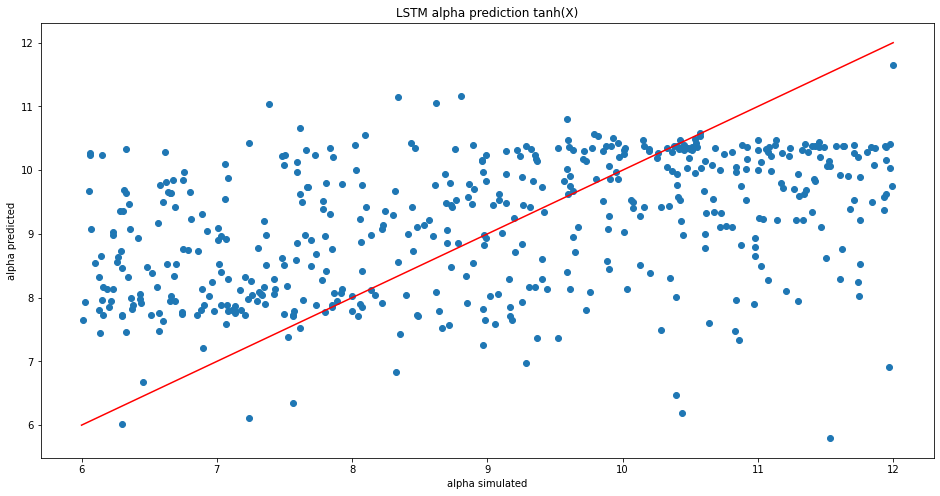

In [14]:
plt.figure(figsize=(16,8))
plt.plot([6,12], [6,12], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('alpha simulated')
plt.ylabel('alpha predicted')
plt.title('LSTM alpha prediction tanh(X)')
plt.show()

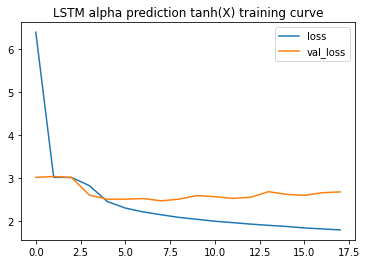

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM alpha prediction tanh(X) training curve')
plt.legend(['loss', 'val_loss'])
plt.show()